<a href="https://colab.research.google.com/github/aminrabinia/StanceDetection_BLM/blob/master/StanceDetection1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from google.colab import files

from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
import nltk

import keras
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, GRU, SimpleRNN
from sklearn import preprocessing
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
np.random.seed(0)
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
   

Using TensorFlow backend.


In [3]:
data_upload=files.upload()
!dir

Saving train.csv to train.csv
sample_data  train.csv


In [4]:
train_df = pd.read_csv('train.csv',index_col=None, header=0, engine='python')
raw_docs_train=[]
classlabels1=[]

for i,row in train_df.iterrows():
  if row[1] =='Hillary Clinton':

    raw_docs_train.append( row['Tweet'])
    classlabels1.append( row['Stance'])

print(len(classlabels1))
#print(raw_docs_train[50])


984


In [5]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])
stop_words.remove('no')
stop_words.remove('not')
stemmer = SnowballStemmer('english')

processed_docs_train = []
for doc in raw_docs_train:
       #doc = doc.decode("utf8")
       tokens = word_tokenize(doc)
       filtered = [word for word in tokens if word not in stop_words]
       stemmed = [stemmer.stem(word) for word in filtered]
       processed_docs_train.append(stemmed)
   
processed_docs_all = processed_docs_train

dictionary = corpora.Dictionary(processed_docs_all)
dictionary_size = len(dictionary.keys())
print ("dictionary size: ", dictionary_size )
    
word_id_train, word_id_len = [], []
for doc in processed_docs_train:
        word_ids = [dictionary.token2id[word] for word in doc]
        word_id_train.append(word_ids)
        word_id_len.append(len(word_ids))

seq_len = np.round((np.mean(word_id_len) + 2*np.std(word_id_len))).astype(int)

#pad sequences
word_id_train = sequence.pad_sequences(np.array(word_id_train), maxlen=seq_len)
     

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
dictionary size:  3468


In [6]:
num_labels = 3

map_st = {
        'NONE':2,
        'AGAINST': 1,
        'FAVOR':0
    }
classlabels1=[map_st[x] for x in classlabels1]
y_train_enc = np_utils.to_categorical(classlabels1)

In [24]:
m=len(classlabels1)
cut=int(m*0.8)

trainX=word_id_train[:cut]
trainY=y_train_enc[:cut]

testX= word_id_train[cut:]
testY=y_train_enc[cut:]

print(len(trainX))
print(len(testX))

787
197


In [25]:
#LSTM
dropout=0.4
model = Sequential()
model.add(Embedding(dictionary_size, 512, dropout=dropout))
model.add(GRU(512, dropout_W=dropout, dropout_U=dropout))
model.add(Dense(256))
model.add(Dropout(dropout))
model.add(Dense(128))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(512, dropout=0.4, recurrent_dropout=0.4)`
  """


In [28]:
opt= keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 512)         1775616   
_________________________________________________________________
gru_2 (GRU)                  (None, 512)               1574400   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_2 (Activation)    (None, 3)                

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 787 samples, validate on 197 samples
Epoch 1/30
787/787 [==============================] - 9s 12ms/step - loss: 1.0524 - accuracy: 0.4816 - val_loss: 1.0521 - val_accuracy: 0.5787
Epoch 2/30
787/787 [==============================] - 9s 11ms/step - loss: 1.0133 - accuracy: 0.5654 - val_loss: 1.0348 - val_accuracy: 0.5787
Epoch 3/30
787/787 [==============================] - 9s 11ms/step - loss: 0.9973 - accuracy: 0.5731 - val_loss: 1.0236 - val_accuracy: 0.5787
Epoch 4/30
787/787 [==============================] - 9s 11ms/step - loss: 0.9834 - accuracy: 0.5705 - val_loss: 1.0163 - val_accuracy: 0.5787
Epoch 5/30
787/787 [==============================] - 9s 11ms/step - loss: 0.9833 - accuracy: 0.5731 - val_loss: 1.0078 - val_accuracy: 0.5787
Epoch 6/30
787/787 [==============================] - 9s 11ms/step - loss: 0.9743 - accuracy: 0.5705 - val_loss: 1.0007 - val_accuracy: 0.5787
Epoch 7/30
787/787 [==============================] - 9s 11ms/step - loss: 0.9567 - accuracy: 0.

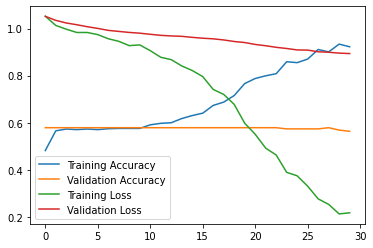

In [29]:
import matplotlib.pyplot as plt

history=model.fit(trainX, trainY, epochs=30, batch_size=100, validation_data=(testX,testY), verbose=1, shuffle=True)

plt.plot(history.epoch, history.history['accuracy'])
plt.plot(history.epoch, history.history['val_accuracy'])
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.legend(['Training Accuracy', 'Validation Accuracy', 
            'Training Loss', 'Validation Loss'])

In [22]:
class Metrics(callbacks.Callback):
    def __init__(self, validation):   
        super(Metrics, self).__init__()
        self.validation = validation    
            
        print('validation shape', len(self.validation[0]))
        
    def on_train_begin(self, logs={}):        
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
     
    def on_epoch_end(self, epoch, logs={}):
        val_targ = self.validation[1]   
        val_predict = (np.asarray(self.model.predict(self.validation[0]))).round()        
    
        val_f1 = f1_score(val_targ, val_predict,average='macro')
        val_recall = recall_score(val_targ, val_predict,average='macro')         
        val_precision = precision_score(val_targ, val_predict,average='macro')
        
        self.val_f1s.append(round(val_f1, 6))
        self.val_recalls.append(round(val_recall, 6))
        self.val_precisions.append(round(val_precision, 6))
 
        print(f' — val_f1: {val_f1} — val_precision: {val_precision}, — val_recall: {val_recall}')

In [23]:
model.compile(loss='binary_crossentropy', optimizer= keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])  
history=model.fit(trainX, trainY, epochs=30, batch_size=100,
                  callbacks=[Metrics(validation=(testX, testY))],  
                  verbose=1,shuffle=True)

validation shape 197


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
787/787 [==============================] - 10s 12ms/step - loss: 0.0130 - accuracy: 0.9992
 — val_f1: 0.4251080794435455 — val_precision: 0.45151072124756336, — val_recall: 0.4263108752272839
Epoch 2/30
787/787 [==============================] - 9s 11ms/step - loss: 0.0138 - accuracy: 0.9983
 — val_f1: 0.40868262555529794 — val_precision: 0.4297865876813245, — val_recall: 0.41775306613873614
Epoch 3/30
787/787 [==============================] - 9s 11ms/step - loss: 0.0059 - accuracy: 0.9983
 — val_f1: 0.3908720697171953 — val_precision: 0.4223686761000194, — val_recall: 0.4237730179791215
Epoch 4/30
787/787 [==============================] - 9s 11ms/step - loss: 0.0088 - accuracy: 0.9992
 — val_f1: 0.4098554719343521 — val_precision: 0.4473770491803279, — val_recall: 0.4422119725083016
Epoch 5/30
600/787 [=====================>........] - ETA: 2s - loss: 4.2404e-04 - accuracy: 1.0000

KeyboardInterrupt: ignored